# Bitcoin Prediction

In [1]:
# Load the stuff..
# Sorry if you see # type: ignore, it's due to me using a type checking linter for other projects

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import shap
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


/home/amos-burton/school/MLClass/bitcoin_project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
# Load the files from data folder. -- Normally would write this differently 
# but didn't realize jupyter notebooks don't have __file__ attribute

output_dir = "../output"
data_directory = "../data"


def load_data(data_directory):
    """
    Load Bitcoin price data and chainlet data from the specified directory.
    
    Args:
        data_directory: Path to the data files.
    
    Returns:
        Tuple of (price_df, amo_chainlets, occ_chainlets) DataFrames.
    """
    csv_file = pathlib.Path(data_directory, "pricedBitcoin2009-2018.csv")
    amo_chainlets_file = pathlib.Path(data_directory, "AmoChainletsInTime.txt")
    occ_chainlets_file = pathlib.Path(data_directory, "OccChainletsInTime.txt")

    # Load price data
    price_df = pd.read_csv(csv_file)
    
    # Convert date column to datetime
    price_df["date"] = pd.to_datetime(price_df["date"])
    price_df["year"] = price_df["date"].dt.year
    price_df["month"] = price_df["date"].dt.month
    price_df["day"] = price_df["date"].dt.day_of_year

    # Load chainlet data
    amo_chainlets = pd.read_csv(amo_chainlets_file, sep="\t")
    occ_chainlets = pd.read_csv(occ_chainlets_file, sep="\t")

    # Clean column names
    amo_chainlets.columns = amo_chainlets.columns.str.strip()
    occ_chainlets.columns = occ_chainlets.columns.str.strip()

    return price_df, amo_chainlets, occ_chainlets


def find_significant_patterns(amo_chainlets, occ_chainlets, start_year=2009, top_n=10):
    """
    Identify the most significant chainlet patterns based on frequency and value.
    
    Args:
        amo_chainlets: DataFrame containing amount chainlet data.
        occ_chainlets: DataFrame containing occurrence chainlet data.
        start_year: Year to start analysis from.
        top_n: Number of top patterns to return.
    
    Returns:
        List of significant chainlet pattern identifiers.
    """
    # Filter data for the relevant time period
    recent_occ = occ_chainlets[occ_chainlets["year"] >= start_year]
    recent_amo = amo_chainlets[amo_chainlets["year"] >= start_year]

    # Get chainlet pattern columns 
    chainlet_cols = [col for col in recent_occ.columns if ":" in col]

    # Calculate total occurrences for each pattern
    pattern_frequency = recent_occ[chainlet_cols].sum()

    # Calculate total amounts for each pattern
    pattern_amounts = recent_amo[chainlet_cols].sum()

    # Calculate average value per transaction for each pattern
    avg_value_per_pattern = pattern_amounts / pattern_frequency
    avg_value_per_pattern = avg_value_per_pattern.replace(
        [np.inf, -np.inf], np.nan
    ).fillna(0)

    # Normalize both metrics
    freq_normalized = (pattern_frequency - pattern_frequency.min()) / (
        pattern_frequency.max() - pattern_frequency.min()
    )
    value_normalized = (avg_value_per_pattern - avg_value_per_pattern.min()) / (
        avg_value_per_pattern.max() - avg_value_per_pattern.min()
    )

    # Combine both metrics into a single score for each chainlet
    pattern_importance = freq_normalized + value_normalized

    # Get top_n most significant patterns
    top_patterns = pattern_importance.nlargest(top_n)

    # Display results in a table
    table = PrettyTable()
    table.field_names = ["Pattern", "Frequency", "Avg Value (satoshis)", "Combined Score"]
    
    for pattern in top_patterns.index:
        table.add_row([
            pattern, 
            f"{pattern_frequency[pattern]:,}",  
            f"{avg_value_per_pattern[pattern]:,.0f}",
            f"{pattern_importance[pattern]:.4f}"
        ])
    
    table.align = "r"  
    table.align["Pattern"] = "l"

    print("\nMost significant chainlet patterns:")
    print(table)

    return top_patterns.index.tolist()

def ensure_both_chainlet_types(significant_patterns, amo_chainlets, occ_chainlets):
    """
    Ensure we select features from both amount and occurrence chainlets.
    
    Args:
        significant_patterns: List of significant patterns identified.
        amo_chainlets: DataFrame with amount chainlet data.
        occ_chainlets: DataFrame with occurrence chainlet data.
    
    Returns:
        List of selected patterns ensuring both types are represented.
    """
    # Explicitly select top patterns from each type
    amo_patterns = significant_patterns[:5]  # Take top 5 amount patterns
    occ_patterns = [p for p in significant_patterns if p not in amo_patterns][:5]  # Take top 5 occurrence patterns
    
    # Combine to ensure we have both types
    selected_patterns = list(set(amo_patterns + occ_patterns))
    
    print(f"\nSelected {len(amo_patterns)} amount chainlet patterns and {len(occ_patterns)} occurrence chainlet patterns")
    return selected_patterns


In [3]:
price_df, amo_chainlets, occ_chainlets = load_data(data_directory=data_directory)

# Add month column for splitting December data
price_df["month"] = pd.to_datetime(price_df["date"]).dt.month

## Prepare Data

In [4]:
def prepare_features(price_df, amo_chainlets, occ_chainlets, start_year=2009):
    """
    Prepare feature dataset by combining price and chainlet data.
    
    Args:
        price_df: DataFrame with Bitcoin price data.
        amo_chainlets: DataFrame with amount chainlet data.
        occ_chainlets: DataFrame with occurrence chainlet data.
        start_year: Year to start analysis from.
    
    Returns:
        DataFrame with combined features for modeling.
    """
    # Filter data from start_year argument
    price_df = price_df[price_df["year"] >= start_year].copy()
    amo_chainlets = amo_chainlets[amo_chainlets["year"] >= start_year].copy()
    occ_chainlets = occ_chainlets[occ_chainlets["year"] >= start_year].copy()
    
    # Create lag features for price (last 7 days)
    for i in range(1, 8):
        price_df[f"price_lag_{i}"] = price_df["price"].shift(i)
    
    # Get significant patterns that include both types
    significant_patterns = find_significant_patterns(amo_chainlets, occ_chainlets)
    selected_patterns = ensure_both_chainlet_types(significant_patterns, amo_chainlets, occ_chainlets)
    
    # Create a date key for joining
    price_df['date_key'] = price_df['year'].astype(str) + '_' + price_df['day'].astype(str)
    amo_chainlets['date_key'] = amo_chainlets['year'].astype(str) + '_' + amo_chainlets['day'].astype(str)
    occ_chainlets['date_key'] = occ_chainlets['year'].astype(str) + '_' + occ_chainlets['day'].astype(str)
    
    # Add chainlet features from the selected patterns
    for pattern in selected_patterns:
        # Create temporary dataframes with just the needed columns
        amo_temp = amo_chainlets[['date_key', pattern]].rename(columns={pattern: f"amo_{pattern}"})
        occ_temp = occ_chainlets[['date_key', pattern]].rename(columns={pattern: f"occ_{pattern}"})
        
        # Join to the price dataframe
        price_df = price_df.merge(amo_temp, on='date_key', how='left')
        price_df = price_df.merge(occ_temp, on='date_key', how='left')
    
    # Drop the temporary key
    price_df = price_df.drop('date_key', axis=1)
    
    # Drop rows with NaN values
    price_df = price_df.dropna()
    
    return price_df


def split_data(df):
    """
    Split data into training, validation, and test sets based on dates.
    
    Args:
        df: DataFrame with prepared features.
    
    Returns:
        Tuple of (train_data, validation_data, test_data) DataFrames.
    """
    # Test Dataset (December 2017)
    test_data = df[(df["year"] == 2017) & (df["month"] == 12)].copy()
    
    # Validation dataset (November 2017)
    validation_data = df[(df["year"] == 2017) & (df["month"] == 11)].copy()
    
    # Training data: All data BEFORE November 2017
    train_data = df[((df["year"] < 2017) | ((df["year"] == 2017) & (df["month"] < 11)))].copy()
    
    print(f"\nData split sizes:")
    print(f"Training set: {len(train_data)} days")
    print(f"Validation set: {len(validation_data)} days")
    print(f"Test set: {len(test_data)} days")
    
    return train_data, validation_data, test_data



def prepare_xy(df):
    """
    Separate features and target variable.
    
    Args:
        df: DataFrame with prepared features.
    
    Returns:
        Tuple of (X, y) with features and target.
    """
    # Remove non-feature columns
    feature_cols = [
        col
        for col in df.columns
        if col not in ["date", "year", "day", "month", "price", "date_key"]
    ]

    X = df[feature_cols]
    y = df["price"]
    return X, y

In [5]:
prepared_df = prepare_features(price_df, amo_chainlets, occ_chainlets)



Most significant chainlet patterns:
+---------+-------------+----------------------+----------------+
| Pattern |   Frequency | Avg Value (satoshis) | Combined Score |
+---------+-------------+----------------------+----------------+
| 1:2     | 164,237,718 |        2,047,304,088 |         1.1778 |
| 1:19    |      56,411 |       10,470,447,513 |         1.0003 |
| 20:20   |     397,814 |        9,487,493,434 |         0.9065 |
| 20:6    |      20,619 |        9,333,171,547 |         0.8891 |
| 10:20   |      36,910 |        8,879,851,602 |         0.8450 |
| 20:17   |      30,096 |        8,663,307,080 |         0.8238 |
| 1:6     |     538,709 |        8,597,810,299 |         0.8205 |
| 20:19   |      24,426 |        8,547,935,223 |         0.8125 |
| 18:12   |         810 |        8,315,133,324 |         0.7896 |
| 20:18   |      25,603 |        8,282,670,849 |         0.7866 |
+---------+-------------+----------------------+----------------+

Selected 5 amount chainlet patterns an

## Train

In [6]:
# Split data
train_data, validation_data, test_data = split_data(prepared_df)

# Prepare features and target for all sets
X_train, y_train = prepare_xy(train_data)
X_val, y_val = prepare_xy(validation_data)
X_test, y_test = prepare_xy(test_data)

# Train model with validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Validate model
val_predictions = model.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_rmse_percent = val_rmse / np.mean(y_val)

# Test model
X_test_scaled = scaler.transform(X_test)
test_predictions = model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_rmse_percent = test_rmse / np.mean(y_test)

# Print results
print("Model Performance Metrics:")
print()
print(f"Validation Set (November 2017)")
print(f"RMSE: ${val_rmse:.2f}")
print()
print(f"Test Set (December 2017)")
print(f"RMSE: ${test_rmse:.2f}")



Data split sizes:
Training set: 2336 days
Validation set: 30 days
Test set: 31 days
Model Performance Metrics:

Validation Set (November 2017)
RMSE: $341.72

Test Set (December 2017)
RMSE: $1122.21


## Evaluate

In [7]:
def evaluate_model(model, scaler, X, y, set_name=""):
    """
    Evaluate model performance on a dataset.
    
    Args:
        model: Trained model.
        scaler: Fitted StandardScaler.
        X: Feature matrix.
        y: Target vector.
        set_name: Name of the dataset (for printing).
    
    Returns:
        Tuple of (rmse, predictions, rmse_percent).
    """
    # Scale features
    X_scaled = scaler.transform(X)

    # Make predictions
    y_pred = model.predict(X_scaled)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mean_price = np.mean(y)
    rmse_percent = (rmse / mean_price)

    print(f"\n{set_name} Set Performance:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"Mean Price: ${mean_price:.2f}")
    print(f"RMSE as % of Mean Price: {rmse_percent:.2%}")

    return rmse, y_pred, rmse_percent

rmse, predictions, rmse_percent = evaluate_model(model, scaler, X_test, y_test)

# Results df
results = pd.DataFrame(
    {
        "Date": test_data["date"],
        "Actual_Price": y_test,
        "Predicted_Price": predictions,
        "Error": y_test - predictions,
    }
)

results["Date"] = pd.to_datetime(results["Date"]).dt.date # Got rid of the random timestamp...



# output results to a csv
prediction_csv = results[["Date", "Predicted_Price"]]
prediction_csv.to_csv(pathlib.Path(output_dir, "laffey_john_predictions.csv"), index=False)



 Set Performance:
RMSE: $1122.21
Mean Price: $15234.93
RMSE as % of Mean Price: 7.37%


## Plot

In [ ]:
# I like seaborn so this is what I used...
# 2 Graphs to show the actual vs predicted prices and the error
def plot_predictions_with_error(results):
    """
    Plot actual vs predicted prices and the error.
    
    Args:
        results: DataFrame with actual and predicted prices.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1])
    
    sns.lineplot(data=results, x="Date", y="Actual_Price", color="orangered", label="Actual Price", marker="o", ax=ax1)
    sns.lineplot(data=results, x="Date", y="Predicted_Price", color="forestgreen", linestyle="--", label="Predicted Price", marker="o", ax=ax1)
    
    ax1.set_xlabel("")
    ax1.set_ylabel("Bitcoin Price (USD)")
    ax1.set_title("Actual vs Predicted Bitcoin Prices (December 2017)")
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True)
    
    sns.lineplot(data=results, x="Date", y="Error", color="red", marker="o", ax=ax2)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Error (USD)")
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to perform SHAP analysis
def analyze_with_shap(model, X_train_scaled, X_test_scaled, X_test, results):
    """
    Analyze model predictions using SHAP.
    
    Args:
        model: Trained model.
        X_train_scaled: Scaled training features (for background).
        X_test_scaled: Scaled test features.
        X_test: Unscaled test features (for feature names).
        results: DataFrame with prediction results.
    """
    print("\n## Model Explanation with SHAP ##")
    
    # Get a representative sample for the background
    X_background = X_train_scaled[:100]  # Use a subset of training data for background
    
    # Create the explainer
    explainer = shap.LinearExplainer(model, X_background)
    
    # Calculate SHAP values for test data
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Removed the overall feature importance plot
    
    # Visualize SHAP values for specific predictions
    sample_indices = [0, 15, 30]  # First day, middle, end of December
    
    for idx in sample_indices:
        # Removed the waterfall plot
        
        # Add clear textual explanation
        print(f"\nExplanation for prediction on {results['Date'].iloc[idx]}:")
        print(f"Actual price: ${results['Actual_Price'].iloc[idx]:.2f}")
        print(f"Predicted price: ${results['Predicted_Price'].iloc[idx]:.2f}")
        
        feature_importance = pd.DataFrame({
            'Feature': X_test.columns,
            'SHAP_Value': shap_values[idx]
        }).sort_values(by='SHAP_Value', key=abs, ascending=False)
        
        # Get top positive and negative influences
        top_positive = feature_importance[feature_importance['SHAP_Value'] > 0].head(3)
        top_negative = feature_importance[feature_importance['SHAP_Value'] < 0].head(3)
        
        print("\nTop features increasing the predicted price:")
        for i, row in top_positive.iterrows():
            print(f"- {row['Feature']}: Increased price by ${row['SHAP_Value']:.2f}")
        
        print("\nTop features decreasing the predicted price:")
        for i, row in top_negative.iterrows():
            print(f"- {row['Feature']}: Decreased price by ${row['SHAP_Value']:.2f}")
        print("\n")

In [9]:
# Load the data
print("Loading data...")
price_df, amo_chainlets, occ_chainlets = load_data(data_directory=data_directory)


Loading data...


In [10]:
# Prepare features
print("\nPreparing features...")
prepared_df = prepare_features(price_df, amo_chainlets, occ_chainlets, start_year=2015)  # Using data from 2015 onward



Preparing features...

Most significant chainlet patterns:
+---------+-------------+----------------------+----------------+
| Pattern |   Frequency | Avg Value (satoshis) | Combined Score |
+---------+-------------+----------------------+----------------+
| 1:2     | 135,215,579 |        1,349,890,305 |         1.0629 |
| 20:18   |       7,353 |       20,238,178,458 |         1.0001 |
| 20:19   |       8,053 |       19,098,510,757 |         0.9435 |
| 20:17   |       9,279 |       18,710,369,398 |         0.9243 |
| 19:17   |         338 |       16,455,208,639 |         0.8123 |
| 20:16   |       8,217 |       13,925,903,481 |         0.6869 |
| 17:17   |         390 |       12,163,740,435 |         0.5994 |
| 20:14   |       9,302 |       11,899,945,847 |         0.5864 |
| 20:15   |       6,923 |       11,896,538,906 |         0.5862 |
| 20:13   |       7,722 |       11,745,848,530 |         0.5787 |
+---------+-------------+----------------------+----------------+

Selected 5 amou

In [11]:
print("\nSplitting data...")
train_data, validation_data, test_data = split_data(prepared_df)

# Prepare features and target for all sets
X_train, y_train = prepare_xy(train_data)
X_val, y_val = prepare_xy(validation_data)
X_test, y_test = prepare_xy(test_data)


Splitting data...

Data split sizes:
Training set: 1027 days
Validation set: 30 days
Test set: 31 days


In [12]:
# Scale features
print("\nScaling features and training model...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Scaling features and training model...


In [13]:
print("\nPerforming time series cross-validation...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

model = LinearRegression()

for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_cv_train, y_cv_train)
    val_pred = model.predict(X_cv_val)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_val, val_pred))
    cv_scores.append(cv_rmse)
    print(f"Fold {i+1} RMSE: ${cv_rmse:.2f}")

print(f"\nAverage CV RMSE: ${np.mean(cv_scores):.2f}")


Performing time series cross-validation...
Fold 1 RMSE: $19.19
Fold 2 RMSE: $27.48
Fold 3 RMSE: $17.49
Fold 4 RMSE: $38.99
Fold 5 RMSE: $164.80

Average CV RMSE: $53.59


In [14]:
model.fit(X_train_scaled, y_train)

# Evaluate on validation set
val_rmse, val_predictions, val_rmse_percent = evaluate_model(model, scaler, X_val, y_val, "Validation")

# Evaluate on test set
test_rmse, test_predictions, test_rmse_percent = evaluate_model(model, scaler, X_test, y_test, "Test")

# Create results DataFrame
results = pd.DataFrame({
    "Date": test_data["date"],
    "Actual_Price": y_test,
    "Predicted_Price": test_predictions,
    "Error": y_test - test_predictions,
})

# Format date for better readability
results["Date"] = pd.to_datetime(results["Date"]).dt.date


Validation Set Performance:
RMSE: $340.84
Mean Price: $7792.85
RMSE as % of Mean Price: 4.37%

Test Set Performance:
RMSE: $1162.03
Mean Price: $15234.93
RMSE as % of Mean Price: 7.63%


RMSE for December 2017: 1122.21


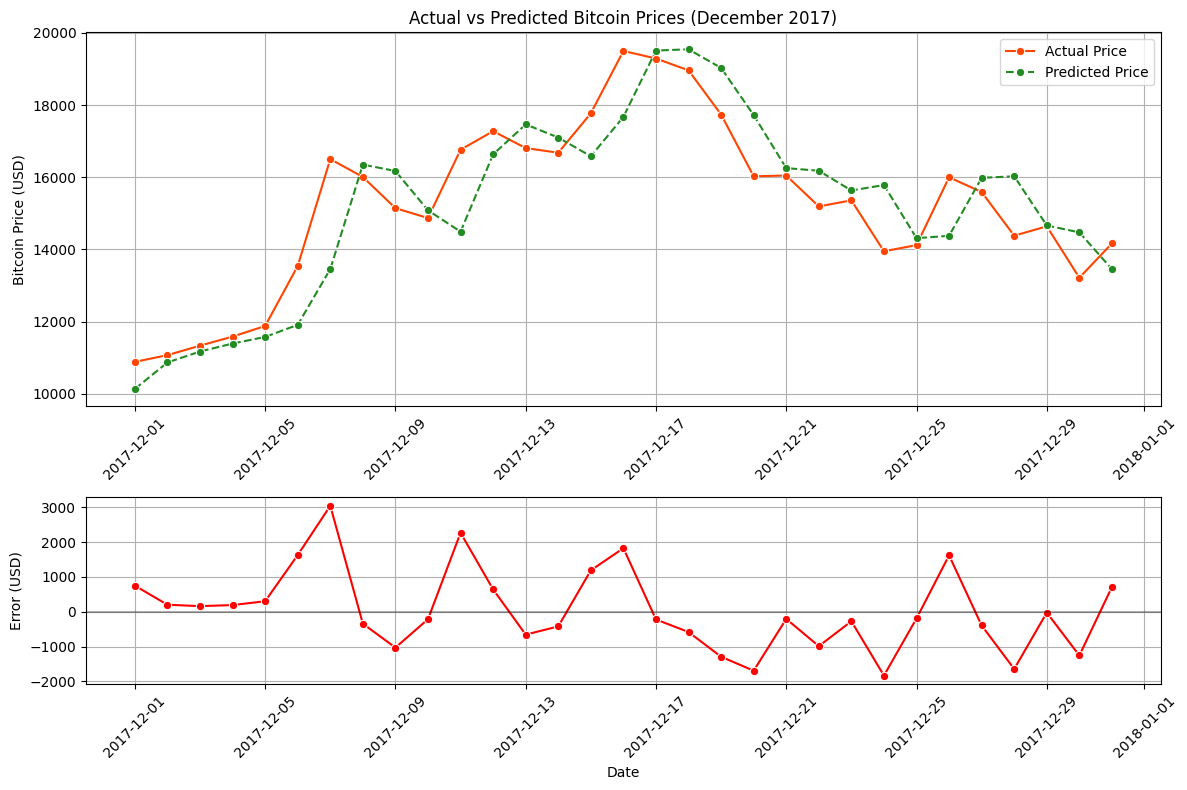

In [15]:
print(f"RMSE for December 2017: {rmse:.2f}")
plot_predictions_with_error(results)



## Model Explanation with SHAP ##


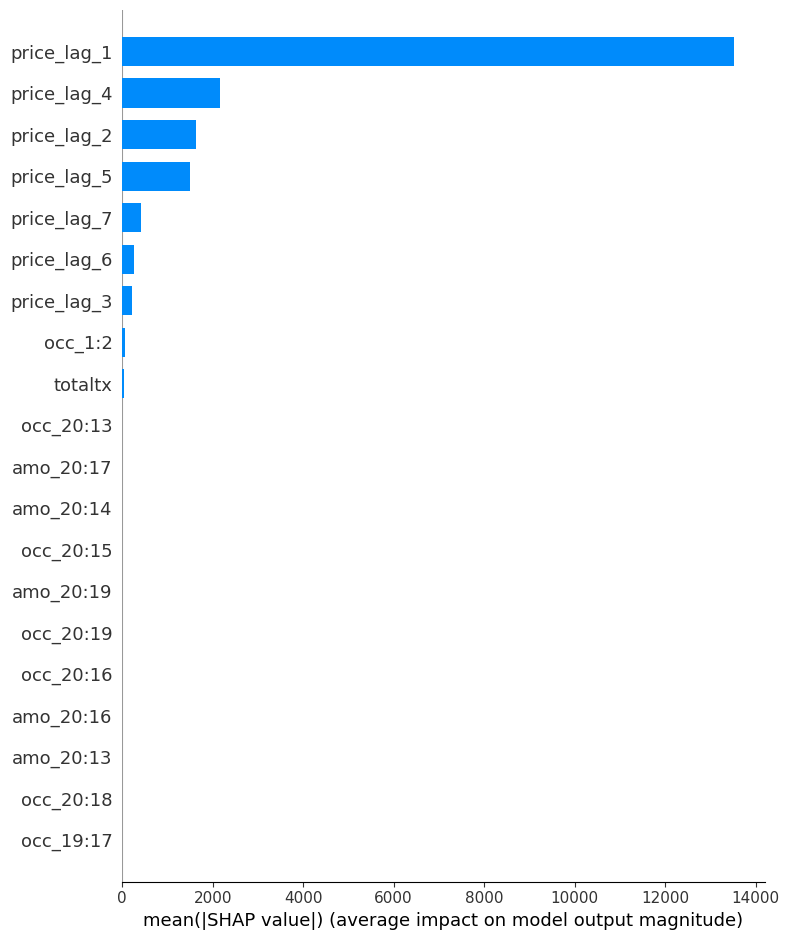

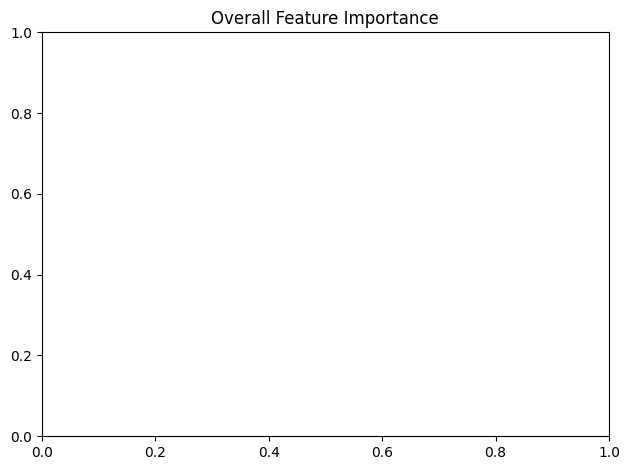

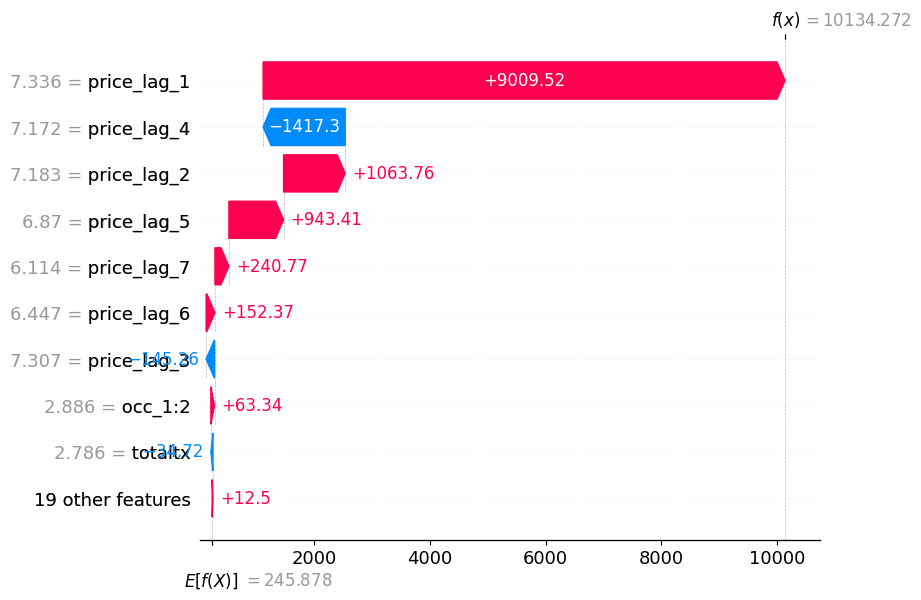

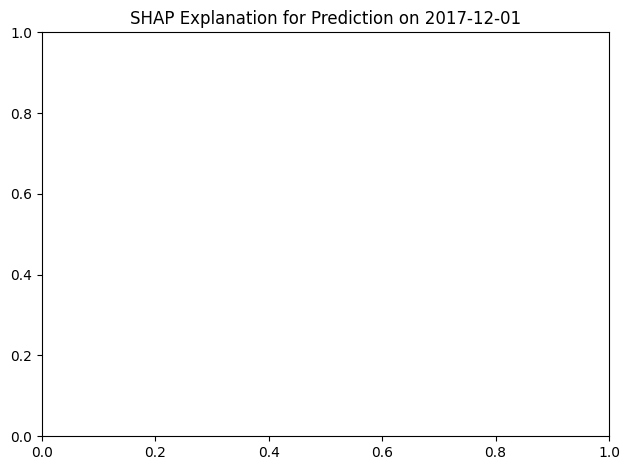


Explanation for prediction on 2017-12-01:
Actual price: $10883.91
Predicted price: $10134.27

Top features increasing the predicted price:
- price_lag_1: Increased price by $9009.52
- price_lag_2: Increased price by $1063.76
- price_lag_5: Increased price by $943.41

Top features decreasing the predicted price:
- price_lag_4: Decreased price by $-1417.30
- price_lag_3: Decreased price by $-145.26
- totaltx: Decreased price by $-34.72




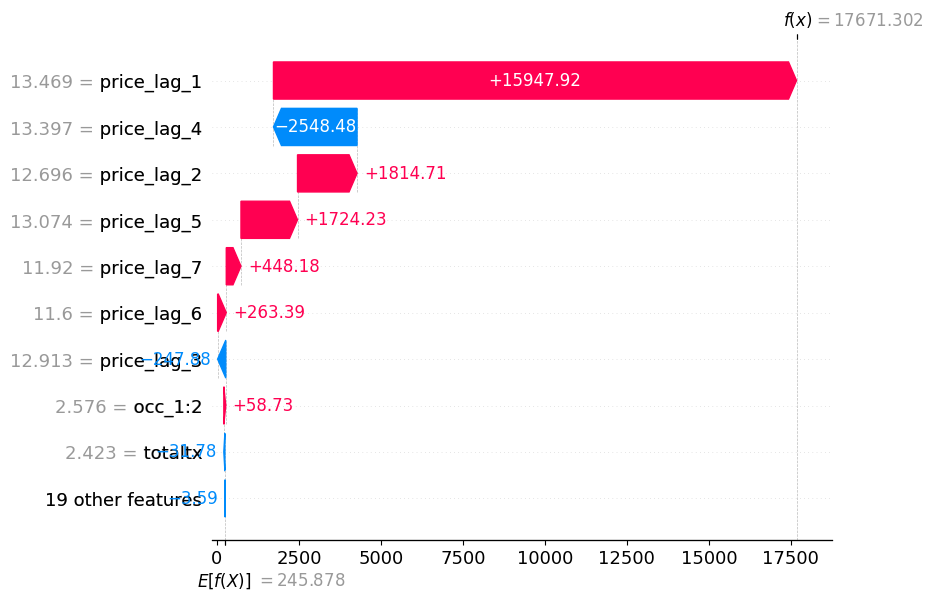

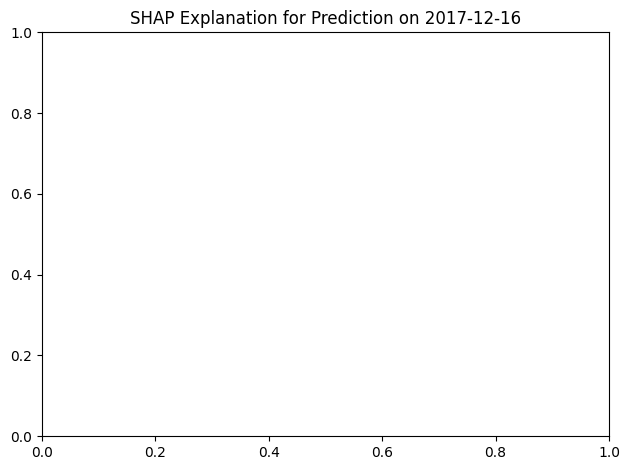


Explanation for prediction on 2017-12-16:
Actual price: $19498.68
Predicted price: $17671.30

Top features increasing the predicted price:
- price_lag_1: Increased price by $15947.92
- price_lag_2: Increased price by $1814.71
- price_lag_5: Increased price by $1724.23

Top features decreasing the predicted price:
- price_lag_4: Decreased price by $-2548.48
- price_lag_3: Decreased price by $-247.88
- totaltx: Decreased price by $-31.78




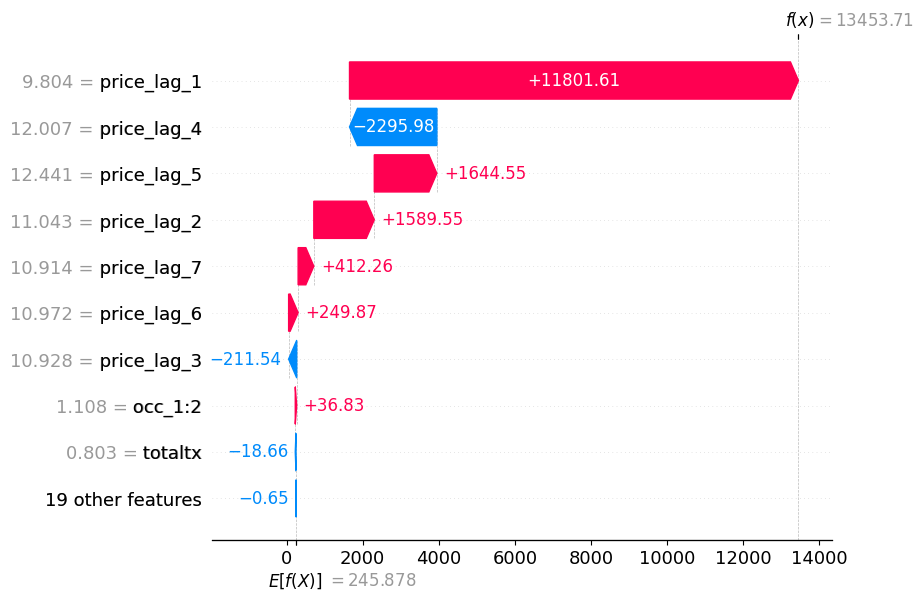

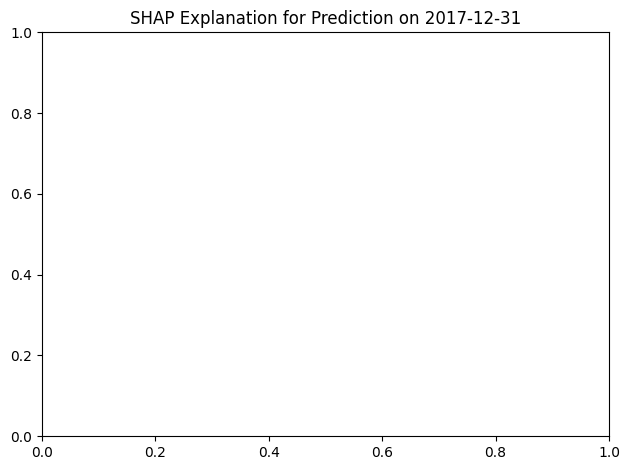


Explanation for prediction on 2017-12-31:
Actual price: $14165.58
Predicted price: $13453.71

Top features increasing the predicted price:
- price_lag_1: Increased price by $11801.61
- price_lag_5: Increased price by $1644.55
- price_lag_2: Increased price by $1589.55

Top features decreasing the predicted price:
- price_lag_4: Decreased price by $-2295.98
- price_lag_3: Decreased price by $-211.54
- totaltx: Decreased price by $-18.66



Predictions saved to ../output/bitcoin_price_predictions_dec2017.csv

Top 10 most important features based on model coefficients:
        Feature  Coefficient  Abs_Coefficient
1   price_lag_1  1131.426292      1131.426292
4   price_lag_4  -181.734239       181.734239
2   price_lag_2   136.215237       136.215237
5   price_lag_5   125.857380       125.857380
7   price_lag_7    35.725844        35.725844
6   price_lag_6    21.544205        21.544205
16    amo_20:14   -19.559597        19.559597
3   price_lag_3   -18.308169        18.308169
27      occ_

In [16]:
analyze_with_shap(model, X_train_scaled, X_test_scaled, X_test, results)

# Save predictions to CSV
prediction_csv = pd.DataFrame({
    "date": results["Date"],
    "predicted_price": results["Predicted_Price"]
})
output_file = pathlib.Path(output_dir, "bitcoin_price_predictions_dec2017.csv")
prediction_csv.to_csv(output_file, index=False)
print(f"\nPredictions saved to {output_file}")

# Feature importance based on model coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 most important features based on model coefficients:")
print(feature_importance.head(10))

# Summary of results
print("\n\n=== Summary ===")
print(f"Test set RMSE: ${test_rmse:.2f}")
print(f"Mean December 2017 Bitcoin price: ${np.mean(y_test):.2f}")
print(f"RMSE as percentage of mean price: {test_rmse_percent:.2%}")
print("\nModel successfully trained and evaluated using both amount and occurrence chainlet features.")
print("SHAP analysis performed to explain model predictions for December 2017.")
